In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression
geo = "GSE17681"

In [2]:
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Keller2009", silent=True)

In [4]:
list(data.gsms.values())[0].metadata

{'title': ['Tumor Sample 1'],
 'geo_accession': ['GSM441129'],
 'status': ['Public on Sep 24 2009'],
 'submission_date': ['Aug 17 2009'],
 'last_update_date': ['Sep 24 2009'],
 'type': ['RNA'],
 'channel_count': ['1'],
 'source_name_ch1': ['blood of tumor patient'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['class label: lung tumor'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': ['It is a known fact that that gene expression in peripheral blood changes post-phlebotomically within a few minutes via transcript induction and degradation (Rainen, Oelmueller et al. 2002; Kruhoffer, Dyrskjot et al. 2007).  To counter this problem, the PAXgeneTM blood sample tubes have been developed. These tubes contain a solution that lyses blood cells and at the same time stabilizes the RNA. By that, the ex vivo changes of expression profiles are avoided. The RNA can be stabilized by PAXgeneâ„¢ system can stabilize RNA for three days at 18-25Â°C, for fi

In [125]:
data.gpls["GPL9040"].table

,ID,SEQUENCE,miRNA_ID
0,hsa-miR-126,ucguaccgugaguaauaaugcg,hsa-miR-126
1,hsa-miR-423-5p,ugaggggcagagagcgagacuuu,hsa-miR-423-5p
2,hsa-let-7i,ugagguaguaguuugugcuguu,hsa-let-7i
3,hsa-let-7d,agagguaguagguugcauaguu,hsa-let-7d
4,hsa-miR-22,aagcugccaguugaagaacugu,hsa-miR-22
...,...,...,...
861,hsa-miR-92a,uauugcacuugucccggccugu,hsa-miR-92a
862,hsa-miR-29b-1*,gcugguuucauauggugguuuaga,hsa-miR-29b-1*
863,hsa-miR-150,ucucccaacccuuguaccagug,hsa-miR-150
864,hsa-miR-335,ucaagagcaauaacgaaaaaugu,hsa-miR-335


In [126]:
table = pd.concat((val.table.iloc[:,1:] for i,val in enumerate(data.gsms.values())), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]

In [127]:
table

,0,1,2,3,4,5,6,7,8,9,...,856,857,858,859,860,861,862,863,864,865
VALUE,84.17,1.00,119.33,1.00,23.56,288.00,1.00,41.28,101.11,1.00,...,1.00,8626.43,6795.89,7392.17,1.00,1.00,1.00,192.67,58.00,1.00
VALUE,26.78,1.00,58.78,9.11,1.00,69.78,1.00,32.78,51.11,1.00,...,9.11,2099.43,4915.83,3303.71,1.00,1.00,13.72,408.44,13.72,1.00
VALUE,18.78,1.00,82.06,1.00,22.67,256.44,1.00,38.33,49.56,1.00,...,2.67,7392.17,5530.88,3428.42,1.00,1.00,1.00,458.72,1.00,1.00
VALUE,47.56,1.00,98.00,15.89,75.33,254.28,1.00,52.44,52.44,9.56,...,15.89,8969.72,3976.97,3778.89,1.00,1.00,9.56,1297.51,34.44,9.56
VALUE,29.11,1.00,60.22,4.78,34.22,121.44,1.00,29.11,75.94,1.89,...,8.67,8626.43,5944.79,5530.88,1.00,1.00,1.00,320.78,12.00,1.00
VALUE,1.00,1.00,57.00,1.00,1.00,32.00,1.00,1.00,32.00,32.00,...,1.00,2575.72,7639.53,998.38,1.00,1.00,1.00,75.33,1.00,1.00
VALUE,52.00,15.78,1.00,1.00,1.00,15.78,1.00,2.67,15.78,15.78,...,1.00,1466.75,12517.64,586.78,1.00,1.00,150.56,209.67,1.00,1.00
VALUE,14.89,1.00,2.67,1.00,1.00,21.44,1.00,1.00,55.56,81.67,...,1.00,312.11,18004.17,252.11,1.00,14.89,9.56,55.56,1.00,1.00
VALUE,1.00,48.00,1.00,1.00,1.00,27.89,1.00,1.00,57.00,97.33,...,1.00,412.67,10521.90,216.28,1.00,12.33,54.44,48.00,1.00,1.00
VALUE,4.00,58.67,20.56,1.00,1.00,28.00,1.00,1.00,81.11,113.89,...,1.00,367.06,15421.86,450.61,1.00,1.00,34.00,47.39,1.00,1.00


### Seperate case and controls

In [128]:
sick = np.array(["Tumor" in k.metadata["title"][0] for k in list(data.gsms.values())])
controls = 1 - sick

In [129]:
sum(controls)

19

### Remove constant values

In [130]:
mask = table.std() != 0
table = table.loc[:, mask]
mirnas = mirnas[mask]

### T-test

In [131]:
X = table

In [132]:
X

,0,1,2,3,4,5,6,7,8,9,...,856,857,858,859,860,861,862,863,864,865
VALUE,84.17,1.00,119.33,1.00,23.56,288.00,1.00,41.28,101.11,1.00,...,1.00,8626.43,6795.89,7392.17,1.00,1.00,1.00,192.67,58.00,1.00
VALUE,26.78,1.00,58.78,9.11,1.00,69.78,1.00,32.78,51.11,1.00,...,9.11,2099.43,4915.83,3303.71,1.00,1.00,13.72,408.44,13.72,1.00
VALUE,18.78,1.00,82.06,1.00,22.67,256.44,1.00,38.33,49.56,1.00,...,2.67,7392.17,5530.88,3428.42,1.00,1.00,1.00,458.72,1.00,1.00
VALUE,47.56,1.00,98.00,15.89,75.33,254.28,1.00,52.44,52.44,9.56,...,15.89,8969.72,3976.97,3778.89,1.00,1.00,9.56,1297.51,34.44,9.56
VALUE,29.11,1.00,60.22,4.78,34.22,121.44,1.00,29.11,75.94,1.89,...,8.67,8626.43,5944.79,5530.88,1.00,1.00,1.00,320.78,12.00,1.00
VALUE,1.00,1.00,57.00,1.00,1.00,32.00,1.00,1.00,32.00,32.00,...,1.00,2575.72,7639.53,998.38,1.00,1.00,1.00,75.33,1.00,1.00
VALUE,52.00,15.78,1.00,1.00,1.00,15.78,1.00,2.67,15.78,15.78,...,1.00,1466.75,12517.64,586.78,1.00,1.00,150.56,209.67,1.00,1.00
VALUE,14.89,1.00,2.67,1.00,1.00,21.44,1.00,1.00,55.56,81.67,...,1.00,312.11,18004.17,252.11,1.00,14.89,9.56,55.56,1.00,1.00
VALUE,1.00,48.00,1.00,1.00,1.00,27.89,1.00,1.00,57.00,97.33,...,1.00,412.67,10521.90,216.28,1.00,12.33,54.44,48.00,1.00,1.00
VALUE,4.00,58.67,20.56,1.00,1.00,28.00,1.00,1.00,81.11,113.89,...,1.00,367.06,15421.86,450.61,1.00,1.00,34.00,47.39,1.00,1.00


In [133]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [134]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [135]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [136]:
mirnas.iloc[lowest], pvalues

(501       hsa-miR-126
 526    hsa-miR-423-5p
 701        hsa-let-7d
 206        hsa-let-7i
 673        hsa-miR-98
 Name: ID_REF, dtype: object,
 array([4.32144335e-08, 1.39343121e-06, 1.18168708e-05, 1.48717781e-05,
        3.60746428e-05]))

### F-test

In [137]:
t3 = table

In [138]:
f, p = f_classif(t3, sick)

In [139]:
np.mean(p)

0.28677823609274233

### ANOVA

In [140]:
t3

,0,1,2,3,4,5,6,7,8,9,...,856,857,858,859,860,861,862,863,864,865
VALUE,84.17,1.00,119.33,1.00,23.56,288.00,1.00,41.28,101.11,1.00,...,1.00,8626.43,6795.89,7392.17,1.00,1.00,1.00,192.67,58.00,1.00
VALUE,26.78,1.00,58.78,9.11,1.00,69.78,1.00,32.78,51.11,1.00,...,9.11,2099.43,4915.83,3303.71,1.00,1.00,13.72,408.44,13.72,1.00
VALUE,18.78,1.00,82.06,1.00,22.67,256.44,1.00,38.33,49.56,1.00,...,2.67,7392.17,5530.88,3428.42,1.00,1.00,1.00,458.72,1.00,1.00
VALUE,47.56,1.00,98.00,15.89,75.33,254.28,1.00,52.44,52.44,9.56,...,15.89,8969.72,3976.97,3778.89,1.00,1.00,9.56,1297.51,34.44,9.56
VALUE,29.11,1.00,60.22,4.78,34.22,121.44,1.00,29.11,75.94,1.89,...,8.67,8626.43,5944.79,5530.88,1.00,1.00,1.00,320.78,12.00,1.00
VALUE,1.00,1.00,57.00,1.00,1.00,32.00,1.00,1.00,32.00,32.00,...,1.00,2575.72,7639.53,998.38,1.00,1.00,1.00,75.33,1.00,1.00
VALUE,52.00,15.78,1.00,1.00,1.00,15.78,1.00,2.67,15.78,15.78,...,1.00,1466.75,12517.64,586.78,1.00,1.00,150.56,209.67,1.00,1.00
VALUE,14.89,1.00,2.67,1.00,1.00,21.44,1.00,1.00,55.56,81.67,...,1.00,312.11,18004.17,252.11,1.00,14.89,9.56,55.56,1.00,1.00
VALUE,1.00,48.00,1.00,1.00,1.00,27.89,1.00,1.00,57.00,97.33,...,1.00,412.67,10521.90,216.28,1.00,12.33,54.44,48.00,1.00,1.00
VALUE,4.00,58.67,20.56,1.00,1.00,28.00,1.00,1.00,81.11,113.89,...,1.00,367.06,15421.86,450.61,1.00,1.00,34.00,47.39,1.00,1.00


In [141]:
X = np.array(sick).reshape(-1, 1)

In [142]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [143]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.06576031813134062

### Mean-variance-plot

In [144]:
np.mean(table)

0       29.557500
1       13.077500
2       51.201111
3       14.908889
4       26.078333
          ...    
861      7.447500
862     18.318333
863    188.353333
864      9.235833
865     13.798889
Length: 865, dtype: float64

In [145]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [146]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

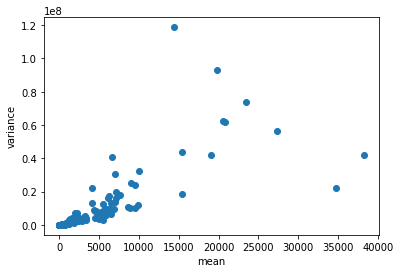

In [147]:
mean_variance_plot(table)

### Log transformation

In [148]:
log_table = np.log2(table)

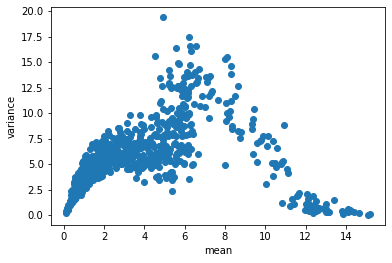

In [149]:
mean_variance_plot(log_table)

In [150]:
mask = np.mean(log_table) > 3
log_table = log_table.loc[:, mask]
mirnas = mirnas[mask]

### Loess regression

In [151]:
lowess = LowessRegression(sigma=1, span=0.1)

In [152]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [153]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

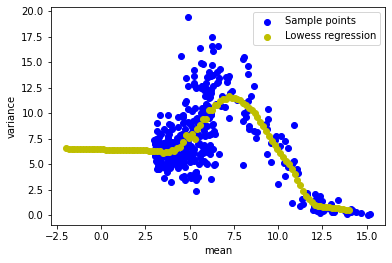

In [154]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

### Lowess normalization

In [155]:
adj_var = lowess.predict(means.to_numpy().reshape(-1, 1))

In [156]:
log_table /= np.sqrt(adj_var)

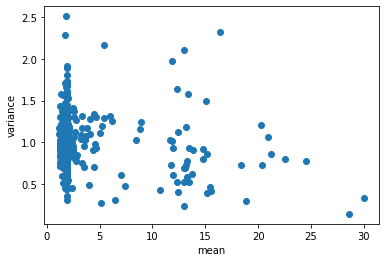

In [157]:
mean_variance_plot(log_table)

In [158]:
norm_log_table = log_table - np.mean(log_table)

In [159]:
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

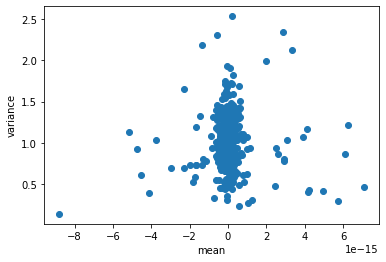

In [160]:
mean_variance_plot(norm_log_table)

### PCA

In [161]:
pca = decomposition.PCA(n_components=10)

In [162]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [163]:
pca.explained_variance_ratio_

array([0.22965804, 0.18556868, 0.10786282, 0.06986837, 0.04634162,
       0.03587015, 0.03333122, 0.03226824, 0.02836934, 0.02741108])

In [164]:
components = pca.transform(norm_log_table)

In [165]:
components.shape

(36, 10)

In [166]:
sum(controls)

19

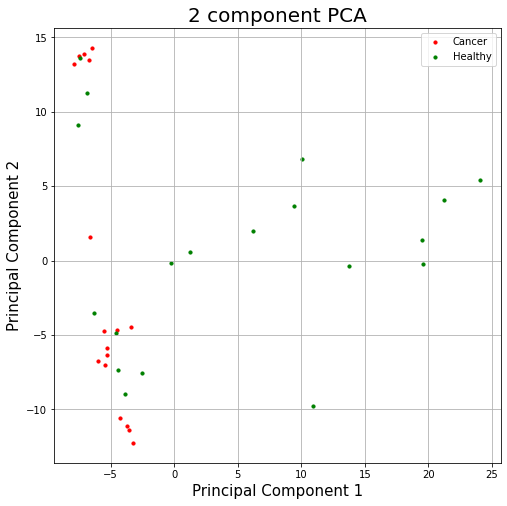

In [167]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [168]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

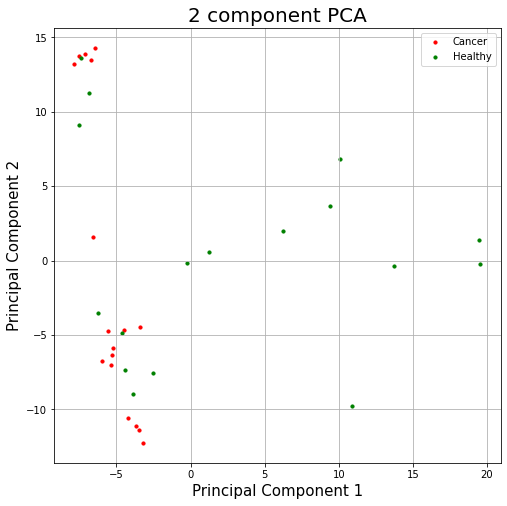

In [169]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [170]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [171]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

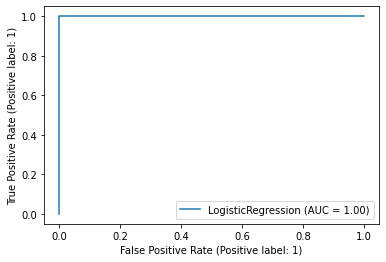

In [172]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [173]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[15:45:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

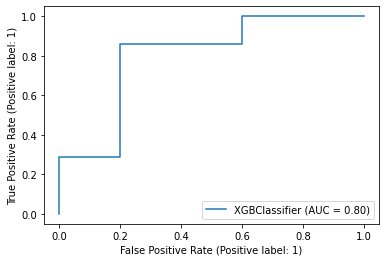

In [174]:
plot_roc_curve(model, X_test, y_test)

### Exporting data

In [175]:
lookup_table = data.gpls["GPL9040"].table

In [176]:
lookup_table = lookup_table.set_index("ID")

In [177]:
mirnas

0          hsa-miR-890
2      hsa-miR-516a-5p
5       hsa-miR-139-3p
7          hsa-miR-453
8       hsa-miR-628-3p
            ...       
852     hsa-miR-138-1*
857        hsa-miR-765
858       hsa-miR-320a
859    hsa-miR-1224-5p
863        hsa-miR-940
Name: ID_REF, Length: 389, dtype: object

In [178]:
sequences = lookup_table.loc[mirnas]["SEQUENCE"]

In [179]:
sequences = [s.upper() for s in sequences]

In [180]:
sequences[:10]

['UACUUGGAAAGGCAUCAGUUG',
 'UUCUCGAGGAAAGAAGCACUUUC',
 'GGAGACGCGGCCCUGUUGGAGU',
 'AGGUUGUCCGUGGUGAGUUCGCA',
 'UCUAGUAAGAGUGGCAGUCGA',
 'CAACAAAUCACAGUCUGCCAUA',
 'UGAGCUAAAUGUGUGCUGGGA',
 'GCCUGCUGGGGUGGAACCUGGU',
 'ACGGGUUAGGCUCUUGGGAGCU',
 'CCAAUAUUACUGUGCUGCUUUA']

In [181]:
norm_log_table.columns = sequences
norm_log_table = norm_log_table.loc[:,~norm_log_table.columns.duplicated()]
norm_log_table["cancer"] = sick

In [182]:
norm_log_table.head()

,UACUUGGAAAGGCAUCAGUUG,UUCUCGAGGAAAGAAGCACUUUC,GGAGACGCGGCCCUGUUGGAGU,AGGUUGUCCGUGGUGAGUUCGCA,UCUAGUAAGAGUGGCAGUCGA,CAACAAAUCACAGUCUGCCAUA,UGAGCUAAAUGUGUGCUGGGA,GCCUGCUGGGGUGGAACCUGGU,ACGGGUUAGGCUCUUGGGAGCU,CCAAUAUUACUGUGCUGCUUUA,...,UGAGGUAGUAGGUUGUAUAGUU,AGGCAGCGGGGUGUAGUGGAUA,CUAGACUGAAGCUCCUUGAGG,GACACGGGCGACAGCUGCGGCCC,GCUACUUCACAACACCAGGGCC,UGGAGGAGAAGGAAGGUGAUG,AAAAGCUGGGUUGAGAGGGCGA,GUGAGGACUCGGGAGGUGG,AAGGCAGGGCCCCCGCUCCCC,cancer
VALUE,1.230933,0.956504,1.111901,0.643108,0.775135,-1.537241,1.169659,1.276524,0.561996,-1.275913,...,-1.571419,0.911081,-0.550154,0.408104,0.520154,1.296237,-0.347394,1.465135,0.513281,True
VALUE,0.558578,0.561178,0.381927,0.509823,0.405091,-1.537241,0.863313,0.919936,-0.117545,0.233398,...,-0.671390,0.956033,-0.748782,-0.102563,1.457285,0.570788,-0.894017,1.113559,0.861160,True
VALUE,0.350232,0.747454,1.052135,0.600245,0.388387,-1.537241,0.387123,0.871127,0.095612,-0.042011,...,-1.603869,1.005340,-0.170655,0.310051,0.724976,1.216971,-0.695042,1.129734,0.914912,True
VALUE,0.895780,0.846561,1.047780,0.781441,0.419025,-0.227601,0.716767,0.820077,0.447182,0.359831,...,-1.508087,0.740256,-0.531753,0.284822,1.106109,1.316270,-1.251741,1.172223,1.396316,True
VALUE,0.607559,0.574691,0.667237,0.441183,0.619864,-1.167959,0.574920,1.023657,0.062082,0.093594,...,-1.477159,0.840232,-0.170655,0.225816,1.117896,1.296237,-0.573233,1.338507,0.749306,True


In [183]:
norm_log_table.to_csv("../TransformedData/Keller2009.csv", index=False)